In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in data (if we have time, come back and look at datatypes and if there is a specific way we want to handle them)
column_names = pd.read_csv('raw_data/column_names.csv', sep=':', header=None)
actual_column_names = column_names.iloc[:,0].tolist()
raw_census_data_learn = pd.read_csv('raw_data/census_income_learn.csv', header=None, names=actual_column_names)
raw_census_data_test = pd.read_csv('raw_data/census_income_test.csv', header=None, names=actual_column_names)
raw_census_data_all = pd.concat([raw_census_data_learn, raw_census_data_test], ignore_index=True)


199523
3229
99762
883
class of worker                                9
education                                     17
enroll in edu inst last wk                     3
marital stat                                   7
major industry code                           24
major occupation code                         15
race                                           5
hispanic origin                               10
sex                                            2
member of a labor union                        3
reason for unemployment                        6
full or part time employment stat              8
tax filer stat                                 6
region of previous residence                   6
state of previous residence                   51
detailed household and family stat            38
detailed household summary in household        8
migration code-change in msa                  10
migration code-change in reg                   9
migration code-move within reg                1

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

In [ ]:
# Some quick data validation checks, uncomment to run

# print("null values ", raw_census_data_all.isnull().sum())
# distinct_counts = raw_census_data_all.select_dtypes(include='object').nunique()
# print(distinct_counts)
# raw_census_data_all.head()
# print(raw_census_data_learn.shape[0])
# print(raw_census_data_learn.duplicated().sum())
# print(raw_census_data_test.shape[0])
# print(raw_census_data_test.duplicated().sum())


In [ ]:
# Some simple data exploration

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

# raw_census_data_all
print("Total raw data records:", raw_census_data_all.shape[0])
print("Total weighted data records:", raw_census_data_all.drop_duplicates().groupby(['year'])['instance weight'].sum())

print("Total weighted records by target", raw_census_data_all.drop_duplicates().groupby(['target', 'year'])['instance weight'].sum())


# check for missing values



Total raw data records: 299285
Total raw data records: year
94   253690657
95   256465897
Name: instance weight, dtype: float64
Total weighted records by target target    year
- 50000.  94     238165195
          95     238748590
50000+.   94      15525462
          95      17717307
Name: instance weight, dtype: float64


In [ ]:
# when we looked at the raw data we saw a similar number of records, the business decsion was made to only include the most recent data, we could do a future investiation to see if this changes year over year
raw_census_data_95 = raw_census_data_all[raw_census_data_all['year'] == 95]

# raw_census_data_95 = raw_census_data_95.drop_duplicates()

sum_instance_weight = raw_census_data_95['instance weight'].sum()
print(f"Total population of us in 95: {sum_instance_weight}")



Total population of us in 95: 262104728.92


In [ ]:
# Remove all people who are under the legal working age of 14? Nah, peopled who are this age might have money from investments from their parents
raw_census_data_over_14 = raw_census_data_95[raw_census_data_95['age'] >= 14]

# We can just check the actual income fields we have to see if a group has made any money
# filter dataset so that each row has at least >0 for the following columns summed: wage per hour, capital gains, dividends from stocks
# raw_census_data_income_recorded = raw_census_data_95[(raw_census_data_95['wage per hour'] > 0) | (raw_census_data_95['capital gains'] > 0) | (raw_census_data_95['dividends from stocks'] > 0)]

# print("Before removing those who make money: {:,.2f}".format(raw_census_data_95['instance weight'].sum()))
# print("After: {:,.2f}".format(raw_census_data_income_recorded['instance weight'].sum()))


# Drop duplicates, each row should be unqiue (Might need to revisit to see what they mean about this because my duplicate analysis doesnt line up with theirs)


# after talking with the business they believe that these features will have the biggest impact on weather or not someone makes over or under 50K a year.
columns_to_keep = [
    'sex', 'full or part time employment stat', 'age', 'member of a labor union', 
    'country of birth self', 'education', 'major occupation code', 'wage per hour', 
    'capital gains', 'capital losses', 'dividends from stocks', 'weeks worked in year', 
    'instance weight', 'target'
]

raw_census_data_income_recorded_slim = raw_census_data_over_14[columns_to_keep]

In [ ]:
# Have a quick look at our selected data
cat_columns = [
    'sex', 
    'full or part time employment stat', 
    'member of a labor union', 
    'country of birth self', 
    'education', 
    'major occupation code'
]

# Continuous columns
cont_columns = ['age', 'wage per hour', 'capital gains', 
                'capital losses', 'dividends from stocks', 
                'weeks worked in year'
            ]

def generate_census_summary(df):
    """Generate summary statistics for census data"""
    summary = {}
    
    # Categorical column summaries
    summary['categorical'] = {}
    for col in cat_columns:
        summary['categorical'][col] = {
            'unique_values': df[col].nunique(),
            'top_5_values': df[col].value_counts().head().to_dict(),
            'missing_values': df[col].isnull().sum()
        }
    
    # Continuous column summaries
    summary['continuous'] = {}
    for col in cont_columns:
        summary['continuous'][col] = {
            'mean': df[col].mean(),
            'median': df[col].median(),
            'std': df[col].std(),
            'min': df[col].min(),
            'max': df[col].max(),
            'missing_values': df[col].isnull().sum()
        }
    
    return summary


summary_stats = generate_census_summary(raw_census_data_income_recorded_slim)
print(summary_stats)


{'categorical': {'sex': {'unique_values': 2, 'top_5_values': {' Female': 61408, ' Male': 54890}, 'missing_values': np.int64(0)}, 'full or part time employment stat': {'unique_values': 8, 'top_5_values': {' Full-time schedules': 61188, ' Not in labor force': 40065, ' PT for non-econ reasons usually FT': 5057, ' Unemployed full-time': 3515, ' Children or Armed Forces': 2646}, 'missing_values': np.int64(0)}, 'member of a labor union': {'unique_values': 3, 'top_5_values': {' Not in universe': 101938, ' No': 12155, ' Yes': 2205}, 'missing_values': np.int64(0)}, 'country of birth self': {'unique_values': 43, 'top_5_values': {' United-States': 100309, ' Mexico': 4059, ' ?': 2449, ' Puerto-Rico': 956, ' Philippines': 682}, 'missing_values': np.int64(0)}, 'education': {'unique_values': 17, 'top_5_values': {' High school graduate': 36020, ' Some college but no degree': 20823, ' Bachelors degree(BA AB BS)': 15185, ' 7th and 8th grade': 5975, ' 10th grade': 5590}, 'missing_values': np.int64(0)}, '

In [ ]:
raw_census_data_income_recorded_slim.to_csv("raw_data/census_income_all_cleaned.csv", ",", index=False, header=True)
census_income_all_slim = pd.read_csv('raw_data/census_income_all_cleaned.csv')
census_income_all_slim.head()

/var/folders/58/sz04nswx0ys7gx6frmv625t00000gn/T/ipykernel_78611/1407756572.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  raw_census_data_income_recorded_slim.to_csv("raw_data/census_income_all_cleaned.csv", ",", index=False, header=True)


,sex,full or part time employment stat,age,member of a labor union,country of birth self,education,major occupation code,wage per hour,capital gains,capital losses,dividends from stocks,weeks worked in year,instance weight,target
0,Female,Not in labor force,73,Not in universe,United-States,High school graduate,Not in universe,0,0,0,0,0,1700.09,- 50000.
1,Female,Not in labor force,18,Not in universe,Vietnam,10th grade,Not in universe,0,0,0,0,0,991.95,- 50000.
2,Female,Full-time schedules,48,No,United-States,Some college but no degree,Professional specialty,1200,0,0,0,52,162.61,- 50000.
3,Female,Unemployed full-time,28,Not in universe,United-States,High school graduate,Handlers equip cleaners etc,0,0,0,0,30,898.83,- 50000.
4,Female,Full-time schedules,47,No,United-States,Some college but no degree,Adm support including clerical,876,0,0,0,52,1661.53,- 50000.


In [39]:
census_income_all_slim
sum_instance_weight = census_income_all_slim['instance weight'].sum()
print(f"Total instance weight: {sum_instance_weight}")

Total instance weight: 205954185.92999998


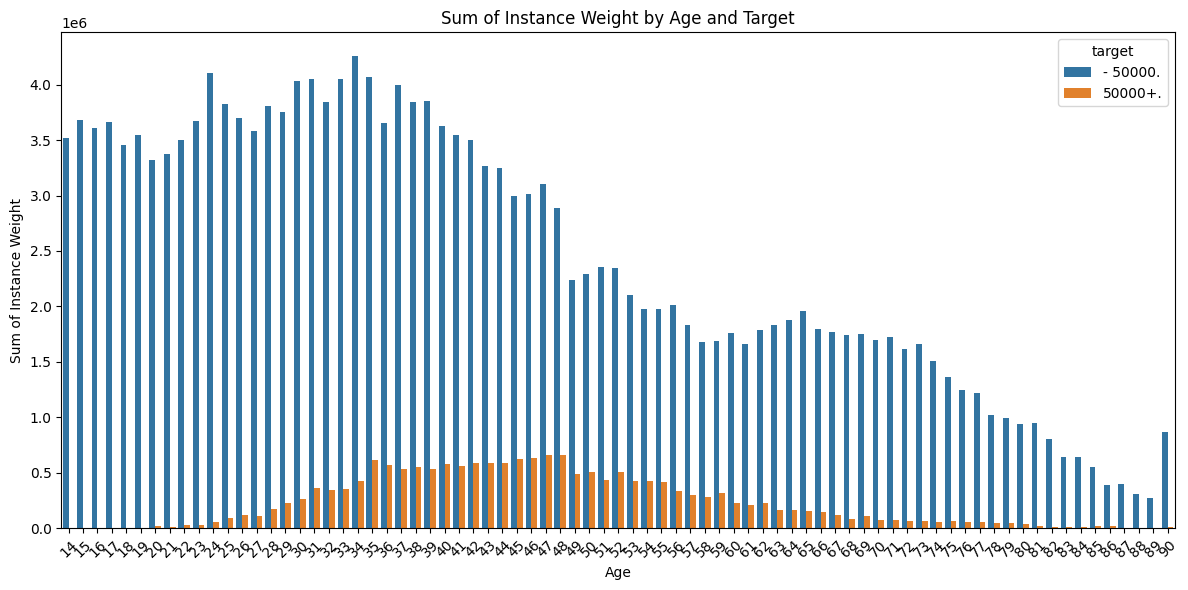

In [134]:
# Quickly looking into why age seems so odd.
plt.figure(figsize=(12, 6))

# Group the data by age and target, then sum the instance weights
age_grouped = census_income_all.groupby(['age', 'target'])['instance weight'].sum().reset_index()

# Create a bar plot
sns.barplot(data=age_grouped, x='age', y='instance weight', hue='target')

plt.xlabel('Age')
plt.ylabel('Sum of Instance Weight')
plt.title('Sum of Instance Weight by Age and Target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

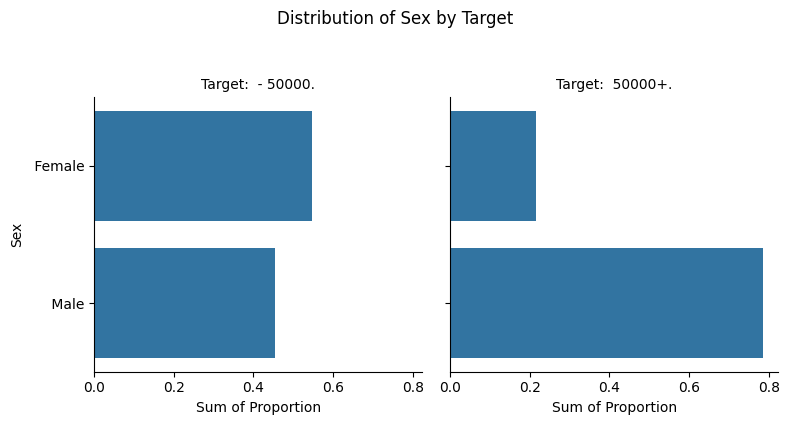

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

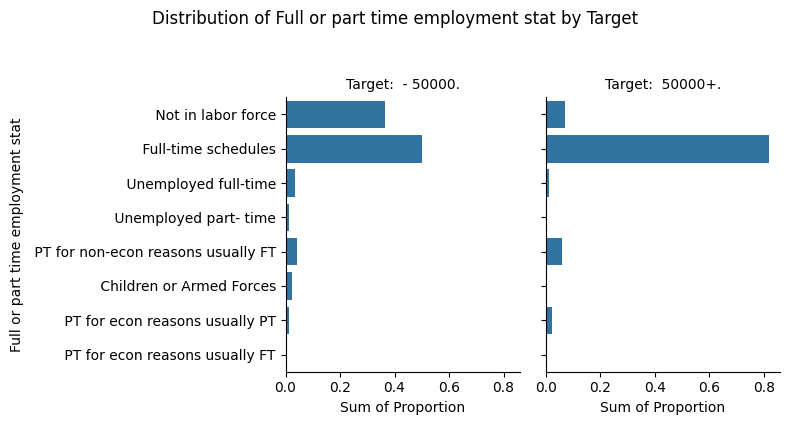

<Figure size 800x600 with 0 Axes>

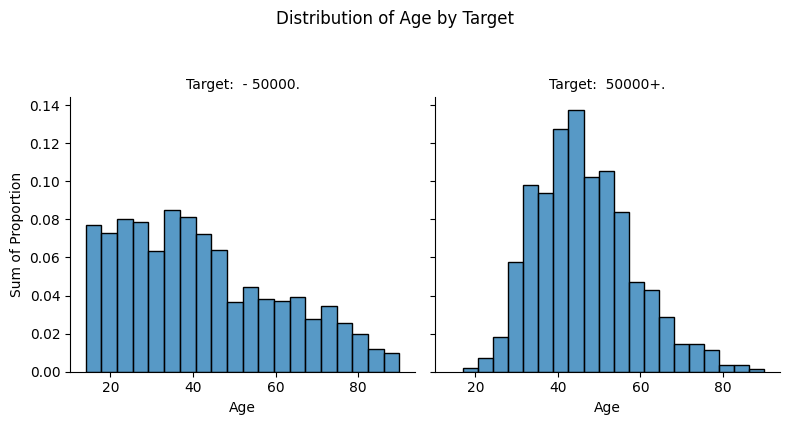

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

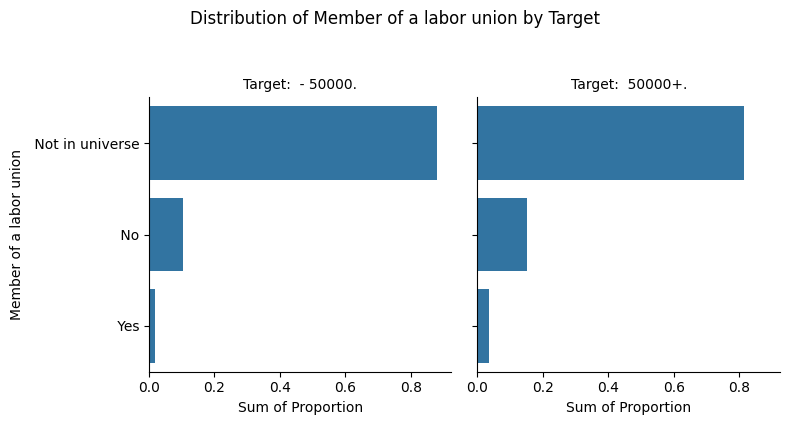

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

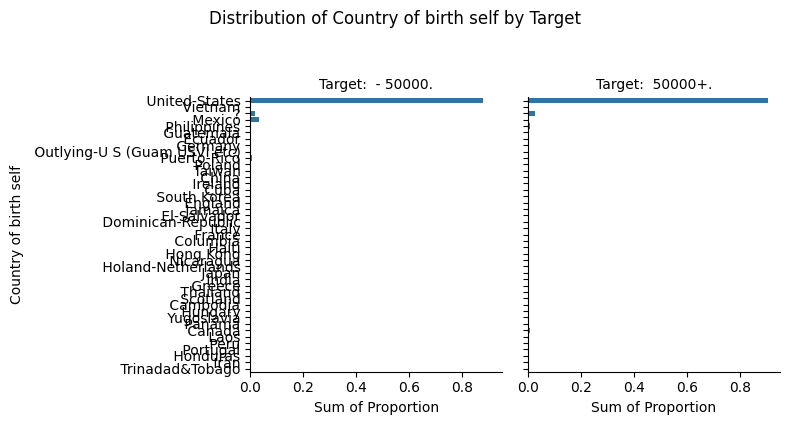

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

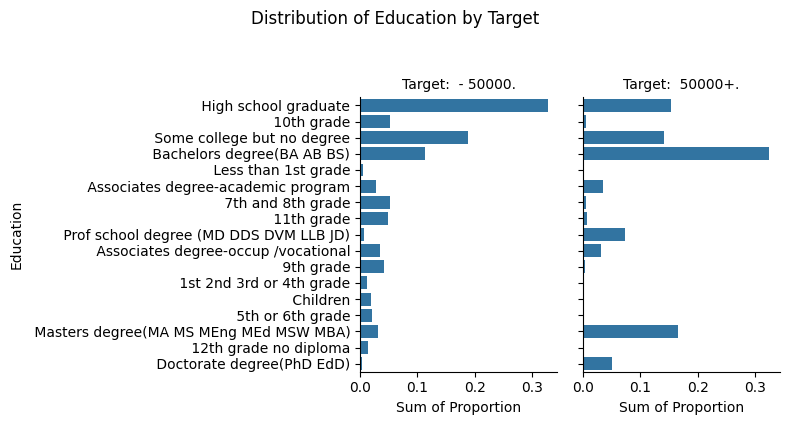

/Users/morleypemberton/Projects/dataiku-casestudy/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x600 with 0 Axes>

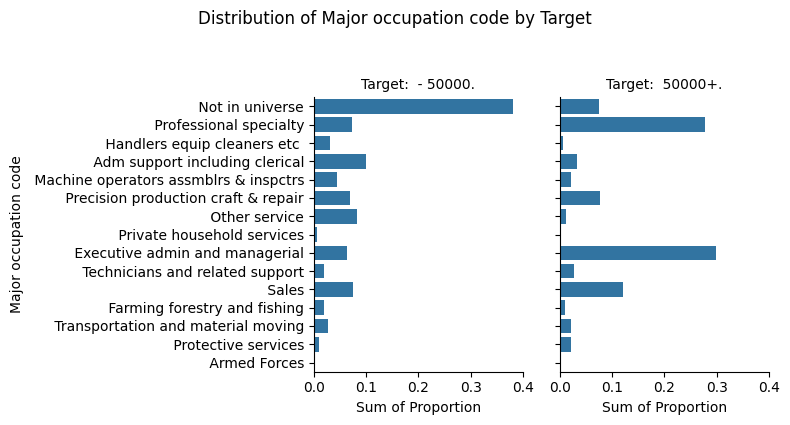

<Figure size 800x600 with 0 Axes>

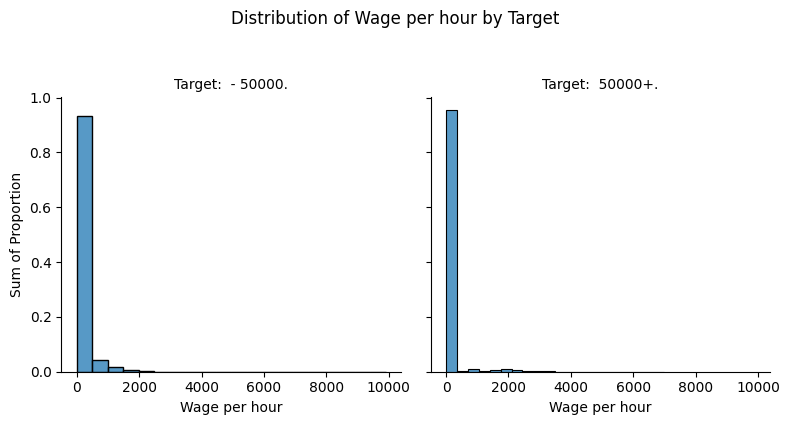

<Figure size 800x600 with 0 Axes>

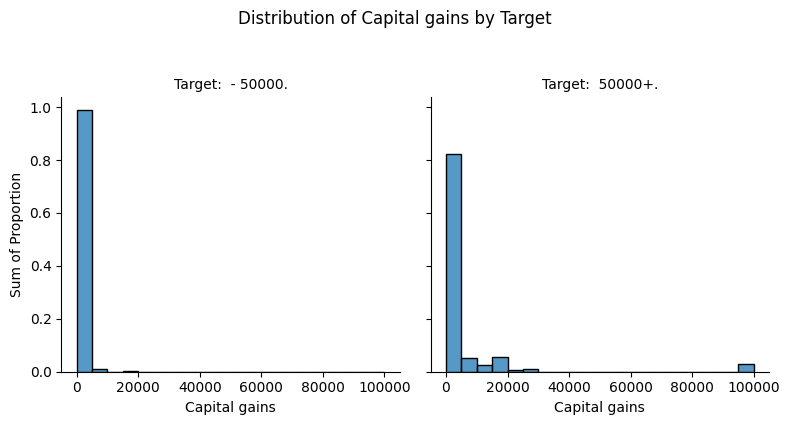

<Figure size 800x600 with 0 Axes>

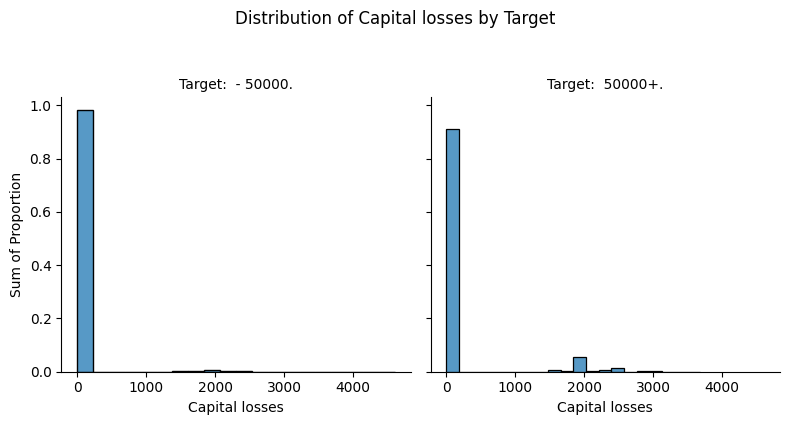

<Figure size 800x600 with 0 Axes>

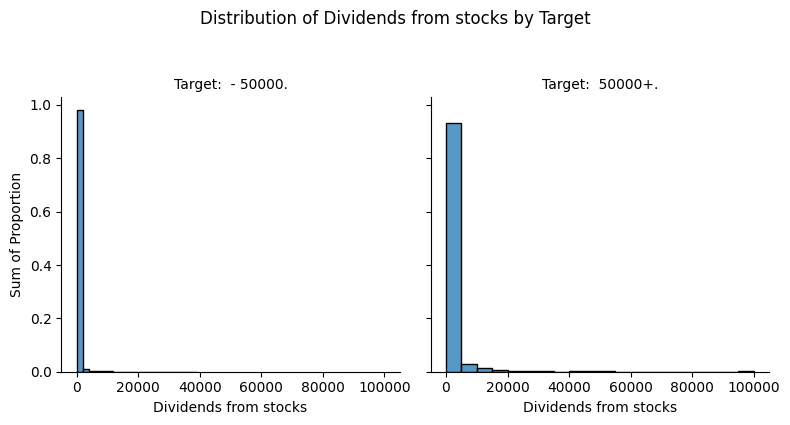

<Figure size 800x600 with 0 Axes>

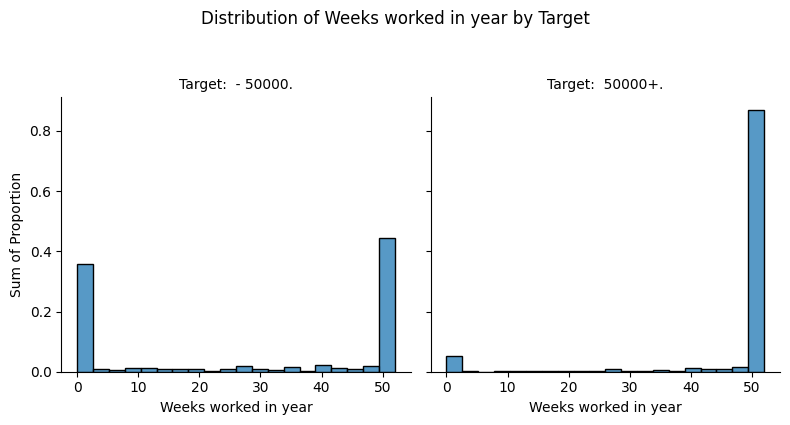

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# List of features to plot
features = ['sex', 'full or part time employment stat', 'age', 'member of a labor union', 
            'country of birth self', 'education', 'major occupation code', 'wage per hour', 
            'capital gains', 'capital losses', 'dividends from stocks', 'weeks worked in year'
        ]
# Define formatter function for millions
millions_formatter = mtick.FuncFormatter(lambda x, pos: f'{int(x*1e-6)}M')

# Calculate total instance weight for each target group
total_instance_weight_by_target = census_income_all_slim.groupby('target')['instance weight'].sum()

# Add a column that is the proportion that row represents of the whole dataset for its target group
census_income_all_slim['proportion'] = census_income_all_slim.apply(lambda row: row['instance weight'] / total_instance_weight_by_target[row['target']], axis=1)

# Update the plotting code to use the new proportion column
for feature in features:
    plt.figure(figsize=(8, 6))
    
    if census_income_all_slim[feature].dtype == 'object':
        # Categorical feature: use bar plot with FacetGrid
        g = sns.FacetGrid(census_income_all_slim, col="target", height=4, aspect=1)
        g.map(sns.barplot, 'proportion', feature, estimator=sum, errorbar=None, orient='h')
        g.set_axis_labels('Sum of Proportion', feature.capitalize())
        g.set_titles(col_template="Target: {col_name}")
        g.fig.suptitle(f'Distribution of {feature.capitalize()} by Target', y=1.05)
    else:
        # Numerical feature: use histogram with FacetGrid
        g = sns.FacetGrid(census_income_all_slim, col="target", height=4, aspect=1)
        g.map(sns.histplot, feature, weights=census_income_all_slim['proportion'], bins=20, kde=False)
        g.set_axis_labels(feature.capitalize(), 'Sum of Proportion')
        g.set_titles(col_template="Target: {col_name}")
        g.fig.suptitle(f'Distribution of {feature.capitalize()} by Target', y=1.05)
    
    plt.tight_layout()
    plt.show()